# 1) Attempt to implement a Single Layer Perceptron in Google Colab to classify the output of an XOR gate.

Importing Libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt

**Creating a Single Layer Perceptron Model.**

In [5]:
class Perceptron:
    def __init__(self, input_dim, learning_rate=0.01, epochs=1000):
        self.weights = np.random.randn(input_dim + 1)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def activation(self, x):
        return 1 if x >= 0 else 0

    def predict(self, X):
        linear_output = np.dot(X, self.weights[1:]) + self.weights[0]
        return np.array([self.activation(x) for x in linear_output])

    def train(self, X, y):
        for epoch in range(self.epochs):
            for xi, target in zip(X, y):
                update = self.learning_rate * (target - self.predict([xi])[0])
                self.weights[1:] += update * xi
                self.weights[0] += update

**Creating the XOR gate's truth table dataset.**

In [6]:
#XOR GATE
#X_xor contains the input values 00,01,10,11
#y_xor contains the output values 0,1,1,0
#The output is 1 only when either of the input is 1 not both.
X_xor = np.array([[0, 0],
                 [0, 1],
                 [1, 0],
                 [1, 1]])
y_xor = np.array([0, 1, 1, 0])

This is the actual truth table for XOR gate :

Input 1: 0, Input 2: 0, Output: 0

Input 1: 0, Input 2: 1, Output: 1

Input 1: 1, Input 2: 0, Output: 1

Input 1: 1, Input 2: 1, Output: 0

**Implement the perceptron model and train it using the XOR dataset using MCP (McCulloch Pitts) Neuron.**

In [ ]:
# Create and train the Perceptron
perceptron_xor = Perceptron(input_dim=2, learning_rate=0.1, epochs=100)
perceptron_xor.train(X_xor, y_xor)

Predictions: [1 1 0 0]
Actual: [0 1 1 0]


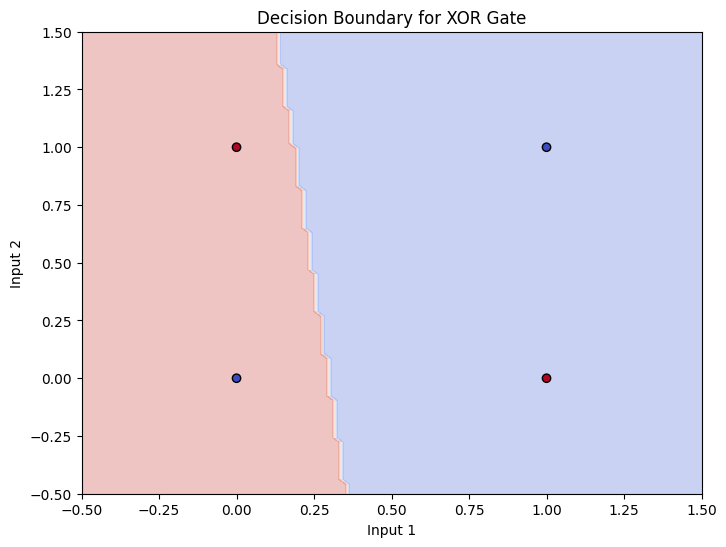

In [7]:
# Make predictions
predictions_xor = perceptron_xor.predict(X_xor)

# Print predictions and actual values
print("Predictions:", predictions_xor)
print("Actual:", y_xor)

def plot_decision_boundary(perceptron, X, y, title):
    plt.figure(figsize=(8, 6))
    x0, x1 = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
    X_mesh = np.c_[x0.ravel(), x1.ravel()]
    predictions = perceptron.predict(X_mesh).reshape(x0.shape)
    plt.contourf(x0, x1, predictions, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o', cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel("Input 1")
    plt.ylabel("Input 2")
    plt.show()

plot_decision_boundary(perceptron_xor, X_xor, y_xor, "Decision Boundary for XOR Gate")

**Observe and discuss the perceptron's performance in this scenario.**

In [51]:
from sklearn.metrics import accuracy_score
acc_score=accuracy_score(y_xor, predictions_xor)
print("Accuracy in Perceptron's Performance in classifying XOR Gate:",acc_score)

Accuracy in Perceptron's Performance in classifying XOR Gate: 0.5


Since the decision boundary between the classes are not linearly seperable meaning no line can seperate the classes, the single layer perceptron was not able to classify the XOR Gate properly. As seen in the graph, the classes are not linearly seperable. We need a multi-layer perceptron to properly classify a XOR GATE

**Implement XOR using Multi-Layer Perceptron.**

In [53]:
## ##

# 2) Sentiment Analysis Twitter Airline : Design a sentiment analysis classification model using backpropagation and activation functions such as sigmoid, ReLU, or tanh. Implement a neural network that can classify sentiment (positive/negative) from a small dataset. Demonstrate how backpropagation updates the weights during the training process.

Importing Libraries

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Reading the dataset

In [34]:
# Load the dataset
data = pd.read_csv("Tweets.csv")

# Extract text and labels
texts = data['text'].values
labels = data['airline_sentiment'].values

data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Preprocessing

In [39]:
# Encoding sentiment labels : positive as 1 and negative as 0
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Convert text labels to numerical (0 and 1)

# Converting text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # Limiting vocabulary to 5000 words and removing stopwords
X = tfidf_vectorizer.fit_transform(texts).toarray()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

**Create a simple feed-forward neural network for binary sentiment classification
(positive/negative).**

In [40]:
def create_model(activation='relu'):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation=activation))  # Hidden layer
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model(activation='relu')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


A simple feed-forward neural network is created with one hidden layer (128 neurons) and an output layer (1 neuron with sigmoid activation for binary classification).

**Use backpropagation to optimize the model's weights based on error calculation**.

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5278 - loss: 0.5675 - val_accuracy: 0.6394 - val_loss: 0.0564
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6422 - loss: -0.2722 - val_accuracy: 0.6150 - val_loss: -0.5711
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6543 - loss: -1.3420 - val_accuracy: 0.6044 - val_loss: -1.3750
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6587 - loss: -2.5451 - val_accuracy: 0.5651 - val_loss: -2.3148
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6439 - loss: -4.3470 - val_accuracy: 0.5967 - val_loss: -3.6364
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6603 - loss: -6.2382 - val_accuracy: 0.5839 - val_loss: -5.0710
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6532 - loss: -9.0702 - val_accuracy: 0.5890 - val_loss: -6.7141
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6460 - loss: -11.9

**Evaluate the model on a test set using accuracy and plot the loss over epochs**.

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5844 - loss: -14.6906
Test Accuracy: 0.5926


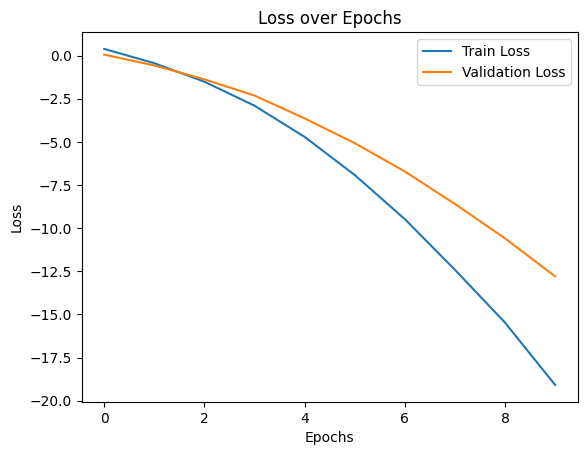

In [42]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ReLU: Pass activation='relu'
Sigmoid: Pass activation='sigmoid'
Tanh: Pass activation='tanh'
Change the activation function and observe how the model's performance changes based on the loss and accuracy plots.

**Experimenting with different activation functions (sigmoid, ReLU, tanh) in the hidden layer and comparing the model's performance.**

In [46]:
tanhmodel = create_model(activation='tanh')
sigmoidmodel = create_model(activation='sigmoid')
tanhhistory = tanhmodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
sigmoidhistory = sigmoidmodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.4962 - loss: 0.5126 - val_accuracy: 0.6103 - val_loss: -0.1004
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6433 - loss: -0.5525 - val_accuracy: 0.5937 - val_loss: -1.0808
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6472 - loss: -2.2009 - val_accuracy: 0.5877 - val_loss: -2.3769
Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3812 - loss: 0.7175 - val_accuracy: 0.3726 - val_loss: 0.5953
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4448 - loss: 0.6078 - val_accuracy: 0.3875 - val_loss: 0.4953
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4849 - loss: 0.4688 - val_accuracy: 0.4959 - val_loss: 0.3549


Tanh Model Evaluation

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5993 - loss: -0.1971
Test Accuracy: 0.6089


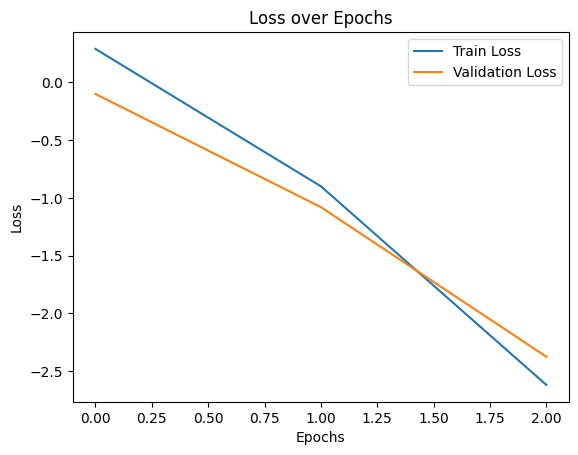

In [47]:
test_loss, test_accuracy = tanhmodel.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.plot(tanhhistory.history['loss'], label='Train Loss')
plt.plot(tanhhistory.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Sigmoid Evaluation

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3755 - loss: 0.5884
Test Accuracy: 0.3702


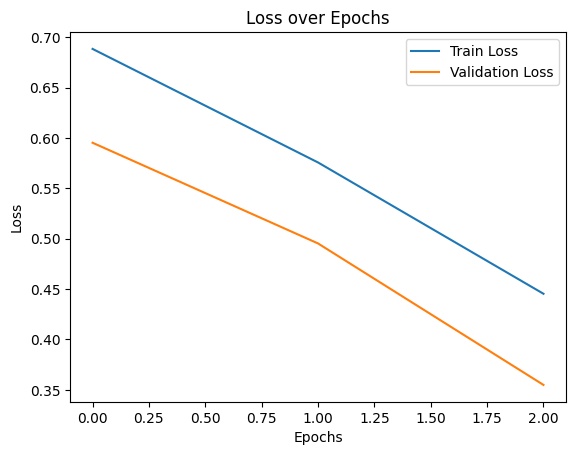

In [48]:
test_loss, test_accuracy = sigmoidmodel.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.plot(sigmoidhistory.history['loss'], label='Train Loss')
plt.plot(sigmoidhistory.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Justify the use of the ReLU and sigmoid activation functions.**
**Explain why binary cross-entropy is suitable for this task.**

ReLU is used because it's simple, efficient, and helps the network learn faster by avoiding problems like small gradients in deeper networks, while the sigmoid function is ideal for binary classification as it converts outputs to probabilities between 0 and 1, making it suitable for predicting positive or negative sentiment. Binary cross-entropy is the best loss function for this task because it measures how well the model's predicted probabilities match the actual binary labels, guiding the model to improve its accuracy during training.

Tanh Model showed the highest accuracy with an accuracy score of 0.6089